**MLP vs CNN vs LSTM vs CNN-LSTMg**

**Import Library**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
# %matplotlib inline
# init_notebook_mode(connected=True)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import legacy
from tensorflow.random import set_seed

from numpy.random import seed
set_seed(1)
seed(1)

**Load the Data**

In [ ]:
filename = 'data.csv'
df = pd.read_csv(filename, sep= ';')
# df.drop(['PRODUCT_CATEGORY','TRANSACTIONS','STORE_CODE'], axis=1, inplace=True)
df['DATE'] =  pd.to_datetime(df['DATE'])
start_date = '2016-05-18'
end_date = '2019-06-18'
df = df[(df['DATE'] >= start_date) & (df['DATE'] <= end_date)]
df['QTY'] = abs(df['QTY'])
# df = df.set_index('DATE')
df = df.sort_values(by='DATE')
# df = df.groupby(by = ['DATE']).sum()
df

,PRODUCT_CATEGORY,DATE,QTY,TRANSACTIONS,STORE_CODE
0,TOPS,2016-05-18,5,5,85
10659,JACKETS,2016-05-18,5,5,387
9995,TOPS,2016-05-18,6,6,387
13455,JACKETS,2016-05-18,7,7,88
1487,SHOES,2016-05-18,1,1,85
...,...,...,...,...,...
25773,JACKETS,2019-06-18,25,25,801
21682,JACKETS,2019-06-18,13,13,617
14563,JACKETS,2019-06-18,10,10,88
1486,JACKETS,2019-06-18,15,15,85


In [ ]:
print('Min date from train set: %s' % df['DATE'].min().date())
print('Max date from train set: %s' % df['DATE'].max().date())

Min date from train set: 2016-05-18
Max date from train set: 2019-06-18


**Exploratory Data Analysis**

In [ ]:
daily_sales = df.groupby('DATE', as_index=False)['QTY'].sum()
monthly_sales = df.groupby(df['DATE'].dt.month)['QTY'].sum()
store_daily_sales = df.groupby(['STORE_CODE', 'DATE'], as_index=False)['QTY'].sum()
product_daily_sales = df.groupby(['PRODUCT_CATEGORY', 'DATE'], as_index=False)['QTY'].sum()

In [ ]:
daily_sales_sc = go.Scatter(x=daily_sales['DATE'], y=daily_sales['QTY'])
layout = go.Layout(title='Daily sales', xaxis=dict(title='DATE'), yaxis=dict(title='QTY'))
fig = go.Figure(data=[daily_sales_sc], layout=layout)
iplot(fig)

In [ ]:
total_sales = monthly_sales.sum()
monthly_sales_percentage = monthly_sales / total_sales * 100

monthly_sales_sc = go.Scatter(x=monthly_sales_percentage.index, y=monthly_sales_percentage.values,
                             mode='lines+markers', text=monthly_sales.round(2),
                             textposition='top center', line=dict(shape='linear'))

annotations = [dict(x=month, y=percentage, text=f"{percentage:.2f}%", showarrow=True, arrowhead=2, ax=0, ay=-40)
               for month, percentage in zip(monthly_sales_percentage.index, monthly_sales_percentage.values)]

layout = go.Layout(title='Monthly Sales Percentage', xaxis=dict(title='Month'), yaxis=dict(title='Percentage'),
                   annotations=annotations)
fig = go.Figure(data=[monthly_sales_sc], layout=layout)
iplot(fig)
print(f"The month with the highest sales: {monthly_sales_percentage.idxmax()} month")

The month with the highest sales: 12 month


In [ ]:
product_daily_sales_sc = []
for product in product_daily_sales['PRODUCT_CATEGORY'].unique():
    current_product_daily_sales = product_daily_sales[(product_daily_sales['PRODUCT_CATEGORY'] == product)]
    product_daily_sales_sc.append(go.Scatter(x=current_product_daily_sales['DATE'], y=current_product_daily_sales['QTY'], name=('PRODUCT_CATEGORY %s' % product)))

layout = go.Layout(title='Product Daily sales', xaxis=dict(title='DATE'), yaxis=dict(title='QTY'))
fig = go.Figure(data=product_daily_sales_sc, layout=layout)
iplot(fig)

In [ ]:
product_total_sales = product_daily_sales.groupby('PRODUCT_CATEGORY')['QTY'].sum()
product_sales_percentage = (product_total_sales / product_total_sales.sum()) * 100

product_sales_sc = go.Scatter(x=product_sales_percentage.index, y=product_sales_percentage.values,
                              mode='lines+markers', text=product_sales_percentage.round(2),
                              textposition='top center', line=dict(shape='linear'))

annotations = [dict(x=product, y=percentage, text=f"{percentage:.2f}%", showarrow=True, arrowhead=2, ax=0, ay=-40)
               for product, percentage in zip(product_sales_percentage.index, product_sales_percentage.values)]

layout = go.Layout(title='Product Sales Percentage', xaxis=dict(title='Product Category'), yaxis=dict(title='Percentage'),
                   annotations=annotations)

fig = go.Figure(data=[product_sales_sc], layout=layout)
iplot(fig)

In [ ]:
product_monthly_sales_sc = []
for product in product_daily_sales['PRODUCT_CATEGORY'].unique():
    current_product_daily_sales = product_daily_sales[product_daily_sales['PRODUCT_CATEGORY'] == product]

    product_monthly_sales = current_product_daily_sales.groupby(current_product_daily_sales['DATE'].dt.month)['QTY'].sum()
    product_monthly_sales_percentage = (product_monthly_sales / product_monthly_sales.sum()) * 100

    product_monthly_sales_sc.append(
        go.Scatter(
            x=product_monthly_sales_percentage.index,
            y=product_monthly_sales_percentage.values,
            mode='lines+markers',
            name=f"PRODUCT_CATEGORY {product} ",
            text=product_monthly_sales_percentage.round(2),
            textposition='top center',
            line=dict(shape='linear')
        )
    )
layout = go.Layout(
    title='Product Monthly Sales Percentage',
    xaxis=dict(title='Month'),
    yaxis=dict(title='Percentage')
)
fig = go.Figure(data=product_monthly_sales_sc, layout=layout)
iplot(fig)

In [ ]:
store_daily_sales_sc = []
for store in store_daily_sales['STORE_CODE'].unique():
    current_store_daily_sales = store_daily_sales[(store_daily_sales['STORE_CODE'] == store)]
    store_daily_sales_sc.append(go.Scatter(x=current_store_daily_sales['DATE'], y=current_store_daily_sales['QTY'], name=('STORE_CODE %s' % store)))

layout = go.Layout(title='Store Daily sales', xaxis=dict(title='Date'), yaxis=dict(title='QTY'))
fig = go.Figure(data=store_daily_sales_sc, layout=layout)
iplot(fig)

In [ ]:
store_total_sales = store_daily_sales.groupby('STORE_CODE')['QTY'].sum()
store_sales_percentage = (store_total_sales / store_total_sales.sum()) * 100

store_sales_sc = go.Scatter(x=store_sales_percentage.index, y=store_sales_percentage.values,
                            mode='lines+markers', text=store_sales_percentage.round(2),
                            textposition='top center', line=dict(shape='linear'))

annotations = [dict(x=store, y=percentage, text=f"{percentage:.2f}%", showarrow=True, arrowhead=2, ax=0, ay=-40)
               for store, percentage in zip(store_sales_percentage.index, store_sales_percentage.values)]

layout = go.Layout(title='Store Sales Percentage', xaxis=dict(title='Store Code', tickmode='array', tickvals=store_sales_percentage.index), yaxis=dict(title='Percentage'),
                   annotations=annotations)

fig = go.Figure(data=[store_sales_sc], layout=layout)
iplot(fig)

**Splitting the DataFrame**

In [ ]:
split_index = int(len(df) * 0.8)
salesbyday_train = df.iloc[:split_index]
salesbyday_test = df.iloc[split_index:]
print('Training set shape:', salesbyday_train.shape)
print('Testing set shape:', salesbyday_test.shape)
print('Training set start date:', salesbyday_train['DATE'].min())
print('Training set end date:', salesbyday_train['DATE'].max())
print('Testing set start date:', salesbyday_test['DATE'].min())
print('Testing set end date:', salesbyday_test['DATE'].max())

Training set shape: (21144, 5)
Testing set shape: (5287, 5)
Training set start date: 2016-05-18 00:00:00
Training set end date: 2018-10-20 00:00:00
Testing set start date: 2018-10-20 00:00:00
Testing set end date: 2019-06-18 00:00:00


**Data Preprocessing**

In [ ]:
lag_size = (salesbyday_test['DATE'].max().date() - salesbyday_train['DATE'].max().date()).days
print('Max date from train set: %s' % salesbyday_train['DATE'].max().date())
print('Max date from test set: %s' % salesbyday_test['DATE'].max().date())
print('Forecast lag size', lag_size)

Max date from train set: 2018-10-20
Max date from test set: 2019-06-18
Forecast lag size 241


In [ ]:
label_encoder = LabelEncoder()
salesbyday_train['PRODUCT_CATEGORY_Encoded'] = label_encoder.fit_transform(salesbyday_train['PRODUCT_CATEGORY'])

In [ ]:
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Product Category Mapping:")
print(label_mapping)

Product Category Mapping:
{'ACCESSORIES': 0, 'JACKETS': 1, 'SHOES': 2, 'SWEATERS': 3, 'TOPS': 4}


In [ ]:
salesbyday_train['PRODUCT_CATEGORY'] = label_encoder.fit_transform(salesbyday_train['PRODUCT_CATEGORY'])
training = salesbyday_train.drop('PRODUCT_CATEGORY_Encoded', axis=1)
training

,PRODUCT_CATEGORY,DATE,QTY,TRANSACTIONS,STORE_CODE
0,4,2016-05-18,5,5,85
10659,1,2016-05-18,5,5,387
9995,4,2016-05-18,6,6,387
13455,1,2016-05-18,7,7,88
1487,2,2016-05-18,1,1,85
...,...,...,...,...,...
27964,3,2018-10-20,14,14,801
22936,0,2018-10-20,1,1,617
13256,4,2018-10-20,4,4,88
16767,4,2018-10-20,0,2,157


In [ ]:
train_gp = salesbyday_train.sort_values('DATE').groupby(['PRODUCT_CATEGORY', 'STORE_CODE', 'DATE'], as_index=False)
train_gp = train_gp.agg({'QTY': 'sum'})
train_gp.columns = ['PRODUCT_CATEGORY', 'STORE_CODE', 'DATE', 'QTY']
train_gp

,PRODUCT_CATEGORY,STORE_CODE,DATE,QTY
0,0,85,2016-06-06,1
1,0,85,2016-06-08,2
2,0,85,2016-06-09,2
3,0,85,2016-06-12,6
4,0,85,2016-06-16,1
...,...,...,...,...
21139,4,801,2018-10-16,4
21140,4,801,2018-10-17,2
21141,4,801,2018-10-18,10
21142,4,801,2018-10-19,12


**Function for transforming the data into a time series problem**

In [ ]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = [], []
    for i in range(window, 0, -1):
        cols += [data.shift(i)]
        names += [f'{col}(t-{i})' for col in data.columns]

    cols += [data, data.shift(-lag)]
    names += [f'{col}(t)' for col in data.columns] + [f'{col}(t+{lag})' for col in data.columns]

    agg = pd.concat(cols, axis=1)
    agg.columns = names

    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
window = 29
lag = lag_size
series = series_to_supervised(train_gp.drop('DATE', axis=1), window=window, lag=lag)
series.head()

,PRODUCT_CATEGORY(t-29),STORE_CODE(t-29),QTY(t-29),PRODUCT_CATEGORY(t-28),STORE_CODE(t-28),...,STORE_CODE(t),QTY(t),PRODUCT_CATEGORY(t+241),STORE_CODE(t+241),QTY(t+241)
29,0.0,85.0,1.0,0.0,85.0,...,85,11,0.0,85.0,1.0
30,0.0,85.0,2.0,0.0,85.0,...,85,17,0.0,85.0,3.0
31,0.0,85.0,2.0,0.0,85.0,...,85,2,0.0,85.0,10.0
32,0.0,85.0,6.0,0.0,85.0,...,85,10,0.0,85.0,4.0
33,0.0,85.0,1.0,0.0,85.0,...,85,2,0.0,85.0,10.0


In [ ]:
last_item = 'PRODUCT_CATEGORY(t-%d)' % window
last_store = 'STORE_CODE(t-%d)' % window
series = series[(series['STORE_CODE(t)'] == series[last_store])]
series = series[(series['PRODUCT_CATEGORY(t)'] == series[last_item])]

In [ ]:
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['STORE_CODE', 'PRODUCT_CATEGORY']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['STORE_CODE', 'PRODUCT_CATEGORY']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['STORE_CODE(t)', 'PRODUCT_CATEGORY(t)'], axis=1, inplace=True)

In [ ]:
pd.set_option('display.max_columns', 10)
series

,QTY(t-29),QTY(t-28),QTY(t-27),QTY(t-26),QTY(t-25),...,QTY(t-3),QTY(t-2),QTY(t-1),QTY(t),QTY(t+241)
29,1.0,2.0,2.0,6.0,1.0,...,4.0,1.0,1.0,11,1.0
30,2.0,2.0,6.0,1.0,2.0,...,1.0,1.0,11.0,17,3.0
31,2.0,6.0,1.0,2.0,1.0,...,1.0,11.0,17.0,2,10.0
32,6.0,1.0,2.0,1.0,1.0,...,11.0,17.0,2.0,10,4.0
33,1.0,2.0,1.0,1.0,1.0,...,17.0,2.0,10.0,2,10.0
...,...,...,...,...,...,...,...,...,...,...,...
20898,1.0,13.0,2.0,7.0,3.0,...,1.0,2.0,1.0,1,4.0
20899,13.0,2.0,7.0,3.0,1.0,...,2.0,1.0,1.0,3,2.0
20900,2.0,7.0,3.0,1.0,2.0,...,1.0,1.0,3.0,3,10.0
20901,7.0,3.0,1.0,2.0,2.0,...,1.0,3.0,3.0,1,12.0


**Splitting Train and Validation**

In [ ]:
labels_col = 'QTY(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)

Train set shape (11845, 30)
Validation set shape (7898, 30)


In [ ]:
X_train.head()

,QTY(t-29),QTY(t-28),QTY(t-27),QTY(t-26),QTY(t-25),...,QTY(t-4),QTY(t-3),QTY(t-2),QTY(t-1),QTY(t)
592,2.0,2.0,2.0,1.0,1.0,...,1.0,3.0,5.0,2.0,2
6907,156.0,118.0,69.0,69.0,38.0,...,93.0,116.0,82.0,18.0,29
6341,3.0,5.0,5.0,9.0,13.0,...,2.0,4.0,4.0,6.0,5
14741,2.0,7.0,3.0,4.0,6.0,...,8.0,2.0,1.0,4.0,2
9456,44.0,52.0,44.0,38.0,25.0,...,4.0,57.0,30.0,30.0,22


**Setting Parameters and Optimization**

In [ ]:
epochs = 40
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)

**MLP Model**

In [ ]:
model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=adam)
model_mlp.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 100)               3100      
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 3201 (12.50 KB)
Trainable params: 3201 (12.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Training the Model**

In [ ]:
mlp_history = model_mlp.fit(X_train.values, Y_train, validation_data=(X_valid.values, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
371/371 - 1s - loss: 321.4321 - val_loss: 209.0999 - 652ms/epoch - 2ms/step
Epoch 2/40
371/371 - 0s - loss: 220.7150 - val_loss: 199.1743 - 379ms/epoch - 1ms/step
Epoch 3/40
371/371 - 0s - loss: 214.1401 - val_loss: 196.0541 - 356ms/epoch - 960us/step
Epoch 4/40
371/371 - 0s - loss: 209.3543 - val_loss: 187.3952 - 286ms/epoch - 772us/step
Epoch 5/40
371/371 - 0s - loss: 206.9629 - val_loss: 188.1382 - 310ms/epoch - 835us/step
Epoch 6/40
371/371 - 0s - loss: 203.5350 - val_loss: 185.7243 - 292ms/epoch - 787us/step
Epoch 7/40
371/371 - 0s - loss: 203.1176 - val_loss: 183.5471 - 307ms/epoch - 827us/step
Epoch 8/40
371/371 - 0s - loss: 202.9531 - val_loss: 184.5623 - 282ms/epoch - 761us/step
Epoch 9/40
371/371 - 0s - loss: 200.8589 - val_loss: 183.0179 - 283ms/epoch - 763us/step
Epoch 10/40
371/371 - 0s - loss: 202.3286 - val_loss: 182.3825 - 291ms/epoch - 785us/step
Epoch 11/40
371/371 - 0s - loss: 200.9082 - val_loss: 182.3836 - 278ms/epoch - 751us/step
Epoch 12/40
371/371 - 0

**Evaluation**

In [ ]:
y_pred = model_mlp.predict(X_valid.values)
y_pred_flat = y_pred.flatten()
y_valid_flat = Y_valid.flatten()
rmse = np.sqrt(mean_squared_error(y_valid_flat, y_pred_flat))
mse = mean_squared_error(y_valid_flat, y_pred_flat)
mae = mean_absolute_error(y_valid_flat, y_pred_flat)
r2 = r2_score(y_valid_flat, y_pred_flat)

print(f'RMSE: {rmse:.4f}')
print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R2: {r2:.4f}')

247/247 [==============================] - 0s 1ms/step
RMSE: 13.6683
MSE: 186.8235
MAE: 7.2543
R2: 0.4025


**CNN**

In [ ]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (11845, 30, 1)
Validation set shape (7898, 30, 1)


In [ ]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu',
                     input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=legacy.Adadelta(lr=0.01))
model_cnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 29, 64)            192       
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 14, 64)            0         
 g1D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 896)               0         
                                                                 
 dense_8 (Dense)             (None, 50)                44850     
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
Total params: 45093 (176.14 KB)
Trainable params: 45093 (176.14 KB)
Non-trainable params: 0 (0.00 Byte)
________________

**Training the Model**

In [ ]:
cnn_history = model_cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
371/371 - 2s - loss: 225.3652 - val_loss: 184.7549 - 2s/epoch - 5ms/step
Epoch 2/40
371/371 - 1s - loss: 207.0320 - val_loss: 184.1730 - 1s/epoch - 4ms/step
Epoch 3/40
371/371 - 2s - loss: 206.5728 - val_loss: 183.8640 - 2s/epoch - 4ms/step
Epoch 4/40
371/371 - 2s - loss: 205.9697 - val_loss: 183.4845 - 2s/epoch - 4ms/step
Epoch 5/40
371/371 - 2s - loss: 205.7627 - val_loss: 182.9797 - 2s/epoch - 4ms/step
Epoch 6/40
371/371 - 2s - loss: 205.3092 - val_loss: 182.9046 - 2s/epoch - 4ms/step
Epoch 7/40
371/371 - 2s - loss: 205.0955 - val_loss: 182.4411 - 2s/epoch - 5ms/step
Epoch 8/40
371/371 - 1s - loss: 204.7198 - val_loss: 182.5993 - 610ms/epoch - 2ms/step
Epoch 9/40
371/371 - 1s - loss: 204.5397 - val_loss: 182.2706 - 585ms/epoch - 2ms/step
Epoch 10/40
371/371 - 1s - loss: 204.4290 - val_loss: 181.9291 - 579ms/epoch - 2ms/step
Epoch 11/40
371/371 - 1s - loss: 204.1887 - val_loss: 181.7003 - 607ms/epoch - 2ms/step
Epoch 12/40
371/371 - 1s - loss: 203.9589 - val_loss: 181.5746

**Evaluation**

In [ ]:
y_pred = model_cnn.predict(X_valid_series)
y_pred_flat = y_pred.flatten()
y_valid_flat = Y_valid.flatten()
rmse = np.sqrt(mean_squared_error(y_valid_flat, y_pred_flat))
mse = mean_squared_error(y_valid_flat, y_pred_flat)
mae = mean_absolute_error(y_valid_flat, y_pred_flat)
r2 = r2_score(y_valid_flat, y_pred_flat)
print(f'RMSE: {rmse:.4f}')
print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R2: {r2:.4f}')

  1/247 [..............................] - ETA: 3s

247/247 [==============================] - 0s 601us/step
RMSE: 13.3828
MSE: 179.0987
MAE: 6.7350
R2: 0.4272


**LSTM**

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1],
                                                        X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=legacy.Adam(lr=0.01))
model_lstm.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 50)                10400     
                                                                 
 dense_14 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Training the Model**

In [ ]:
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
371/371 - 3s - loss: 4531.8965 - val_loss: 189.3242 - 3s/epoch - 8ms/step
Epoch 2/40
371/371 - 2s - loss: 1673199.3750 - val_loss: 176.9986 - 2s/epoch - 6ms/step
Epoch 3/40
371/371 - 2s - loss: 1086012.1250 - val_loss: 1350.5050 - 2s/epoch - 6ms/step
Epoch 4/40
371/371 - 2s - loss: 1126.9303 - val_loss: 1416.0682 - 2s/epoch - 6ms/step
Epoch 5/40
371/371 - 2s - loss: 1024.9619 - val_loss: 1080.9979 - 2s/epoch - 6ms/step
Epoch 6/40
371/371 - 2s - loss: 813.5307 - val_loss: 845.2879 - 2s/epoch - 6ms/step
Epoch 7/40
371/371 - 2s - loss: 499.2441 - val_loss: 323.5590 - 2s/epoch - 6ms/step
Epoch 8/40
371/371 - 2s - loss: 332.8142 - val_loss: 310.7612 - 2s/epoch - 6ms/step
Epoch 9/40
371/371 - 2s - loss: 320.9474 - val_loss: 296.9142 - 2s/epoch - 6ms/step
Epoch 10/40
371/371 - 2s - loss: 307.7188 - val_loss: 282.5797 - 2s/epoch - 6ms/step
Epoch 11/40
371/371 - 2s - loss: 293.5626 - val_loss: 267.4074 - 2s/epoch - 6ms/step
Epoch 12/40
371/371 - 2s - loss: 279.5174 - val_loss: 252.71

**Evaluation**

In [ ]:
y_pred = model_lstm.predict(X_valid_series)
y_pred_flat = y_pred.flatten()
y_valid_flat = Y_valid.flatten()
rmse = np.sqrt(mean_squared_error(y_valid_flat, y_pred_flat))
mse = mean_squared_error(y_valid_flat, y_pred_flat)
mae = mean_absolute_error(y_valid_flat, y_pred_flat)
r2 = r2_score(y_valid_flat, y_pred_flat)
print(f'RMSE: {rmse:.4f}')
print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R2: {r2:.4f}')

247/247 [==============================] - 0s 2ms/step
RMSE: 13.4283
MSE: 180.3184
MAE: 7.0504
R2: 0.4233


**CNN-LSTM for Time Series Forecasting**

In [ ]:
subsequences = 2
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (11845, 2, 15, 1)
Validation set shape (7898, 2, 15, 1)


In [ ]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'),
                                   input_shape=(None, X_train_series_sub.shape[2],
                                                X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=legacy.Adam(lr=0.01))
model_cnn_lstm.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_15 (TimeD  (None, None, 15, 64)      128       
 istributed)                                                     
                                                                 
 time_distributed_16 (TimeD  (None, None, 7, 64)       0         
 istributed)                                                     
                                                                 
 time_distributed_17 (TimeD  (None, None, 448)         0         
 istributed)                                                     
                                                                 
 lstm_9 (LSTM)               (None, 50)                99800     
                                                                 
 dense_17 (Dense)            (None, 1)                 51        
                                                     

**Training the Model**

In [ ]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
371/371 - 2s - loss: 223.2961 - val_loss: 183.5480 - 2s/epoch - 4ms/step
Epoch 2/40
371/371 - 1s - loss: 207.2524 - val_loss: 181.8459 - 931ms/epoch - 3ms/step
Epoch 3/40
371/371 - 1s - loss: 210.0064 - val_loss: 188.6898 - 929ms/epoch - 3ms/step
Epoch 4/40
371/371 - 1s - loss: 209.5585 - val_loss: 187.1067 - 1s/epoch - 3ms/step
Epoch 5/40
371/371 - 1s - loss: 206.2024 - val_loss: 180.6319 - 1s/epoch - 3ms/step
Epoch 6/40
371/371 - 1s - loss: 203.4423 - val_loss: 189.3499 - 1s/epoch - 3ms/step
Epoch 7/40
371/371 - 1s - loss: 202.2767 - val_loss: 178.4108 - 970ms/epoch - 3ms/step
Epoch 8/40
371/371 - 1s - loss: 204.1266 - val_loss: 177.9642 - 1s/epoch - 3ms/step
Epoch 9/40
371/371 - 1s - loss: 200.9453 - val_loss: 177.0550 - 1s/epoch - 3ms/step
Epoch 10/40
371/371 - 1s - loss: 203.3144 - val_loss: 176.9337 - 1s/epoch - 3ms/step
Epoch 11/40
371/371 - 1s - loss: 201.4279 - val_loss: 180.9447 - 1s/epoch - 3ms/step
Epoch 12/40
371/371 - 1s - loss: 201.1256 - val_loss: 176.2185 - 

**Evaluation**

In [ ]:
y_train_pred_cnn_lstm = model_cnn_lstm.predict(X_train_series_sub)
y_valid_pred_cnn_lstm = model_cnn_lstm.predict(X_valid_series_sub)
y_train_pred_flat_cnn_lstm = y_train_pred_cnn_lstm.flatten()
y_valid_pred_flat_cnn_lstm = y_valid_pred_cnn_lstm.flatten()
y_train_flat_cnn_lstm = Y_train.flatten()
y_valid_flat_cnn_lstm = Y_valid.flatten()
train_rmse_cnn_lstm = np.sqrt(mean_squared_error(y_train_flat_cnn_lstm, y_train_pred_flat_cnn_lstm))
train_mse_cnn_lstm = mean_squared_error(y_train_flat_cnn_lstm, y_train_pred_flat_cnn_lstm)
train_mae_cnn_lstm = mean_absolute_error(y_train_flat_cnn_lstm, y_train_pred_flat_cnn_lstm)
train_r2_cnn_lstm = r2_score(y_train_flat_cnn_lstm, y_train_pred_flat_cnn_lstm)
valid_rmse_cnn_lstm = np.sqrt(mean_squared_error(y_valid_flat_cnn_lstm, y_valid_pred_flat_cnn_lstm))
valid_mse_cnn_lstm = mean_squared_error(y_valid_flat_cnn_lstm, y_valid_pred_flat_cnn_lstm)
valid_mae_cnn_lstm = mean_absolute_error(y_valid_flat_cnn_lstm, y_valid_pred_flat_cnn_lstm)
valid_r2_cnn_lstm = r2_score(y_valid_flat_cnn_lstm, y_valid_pred_flat_cnn_lstm)
print("CNN-LSTM Training Metrics:")
print(f'CNN-LSTM Training RMSE: {train_rmse_cnn_lstm:.4f}')
print(f'CNN-LSTM Training MSE: {train_mse_cnn_lstm:.4f}')
print(f'CNN-LSTM Training MAE: {train_mae_cnn_lstm:.4f}')
print(f'CNN-LSTM Training R2: {train_r2_cnn_lstm:.4f}')
print("\nCNN-LSTM Validation Metrics:")
print(f'CNN-LSTM Validation RMSE: {valid_rmse_cnn_lstm:.4f}')
print(f'CNN-LSTM Validation MSE: {valid_mse_cnn_lstm:.4f}')
print(f'CNN-LSTM Validation MAE: {valid_mae_cnn_lstm:.4f}')
print(f'CNN-LSTM Validation R2: {valid_r2_cnn_lstm:.4f}')

247/247 [==============================] - 0s 837us/step
CNN-LSTM Training Metrics:
CNN-LSTM Training RMSE: 14.0454
CNN-LSTM Training MSE: 197.2741
CNN-LSTM Training MAE: 7.2854
CNN-LSTM Training R2: 0.3930

CNN-LSTM Validation Metrics:
CNN-LSTM Validation RMSE: 13.3398
CNN-LSTM Validation MSE: 177.9490
CNN-LSTM Validation MAE: 7.3179
CNN-LSTM Validation R2: 0.4309


**Comparison**

247/247 [==============================] - 0s 445us/step
MLP Metrics:
RMSE: 13.6683
MSE: 186.8235
MAE: 7.2543
R2: 0.4025
247/247 [==============================] - 0s 556us/step
CNN Metrics:
RMSE: 13.3828
MSE: 179.0987
MAE: 6.7350
R2: 0.4272
247/247 [==============================] - 0s 2ms/step
LSTM Metrics:
RMSE: 13.4283
MSE: 180.3184
MAE: 7.0504
R2: 0.4233
247/247 [==============================] - 0s 829us/step
CNN-LSTM Metrics:
RMSE: 13.3398
MSE: 177.9490
MAE: 7.3179
R2: 0.4309


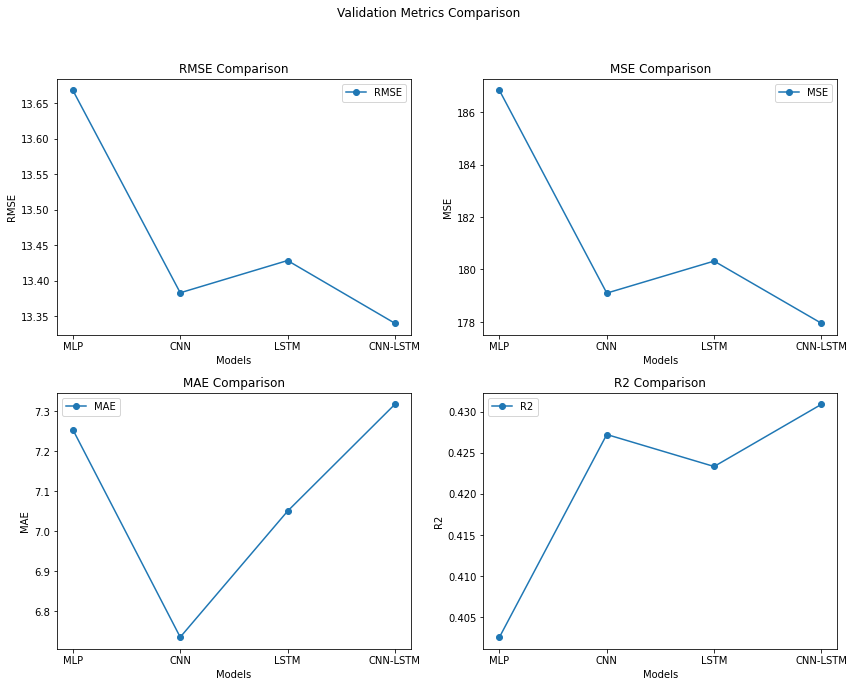

In [ ]:
def evaluate_model(model, X_data, Y_data, model_name):
    y_pred = model.predict(X_data)
    y_pred_flat = y_pred.flatten()
    y_data_flat = Y_data.flatten()

    rmse = np.sqrt(mean_squared_error(y_data_flat, y_pred_flat))
    mse = mean_squared_error(y_data_flat, y_pred_flat)
    mae = mean_absolute_error(y_data_flat, y_pred_flat)
    r2 = r2_score(y_data_flat, y_pred_flat)

    print(f'{model_name} Metrics:')
    print(f'RMSE: {rmse:.4f}')
    print(f'MSE: {mse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'R2: {r2:.4f}')

    return rmse, mse, mae, r2

model_names = ['MLP', 'CNN', 'LSTM', 'CNN-LSTM']
models = [model_mlp, model_cnn, model_lstm, model_cnn_lstm]
X_data_list = [X_valid.values, X_valid_series, X_valid_series, X_valid_series_sub]
Y_data_list = [Y_valid, Y_valid, Y_valid, Y_valid]

all_metrics = []
for model, X_data, Y_data, model_name in zip(models, X_data_list, Y_data_list, model_names):
    metrics = evaluate_model(model, X_data, Y_data, model_name)
    all_metrics.append(metrics)

valid_rmse, valid_mse, valid_mae, valid_r2 = zip(*all_metrics)

metrics_names = ['RMSE', 'MSE', 'MAE', 'R2']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Validation Metrics Comparison')

for i, metric_name in enumerate(metrics_names):
    row, col = i // 2, i % 2
    axes[row, col].plot(model_names, [metric[i] for metric in all_metrics], marker='o', label=metric_name)
    axes[row, col].set_title(f'{metric_name} Comparison')
    axes[row, col].set_xlabel('Models')
    axes[row, col].set_ylabel(metric_name)
    axes[row, col].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


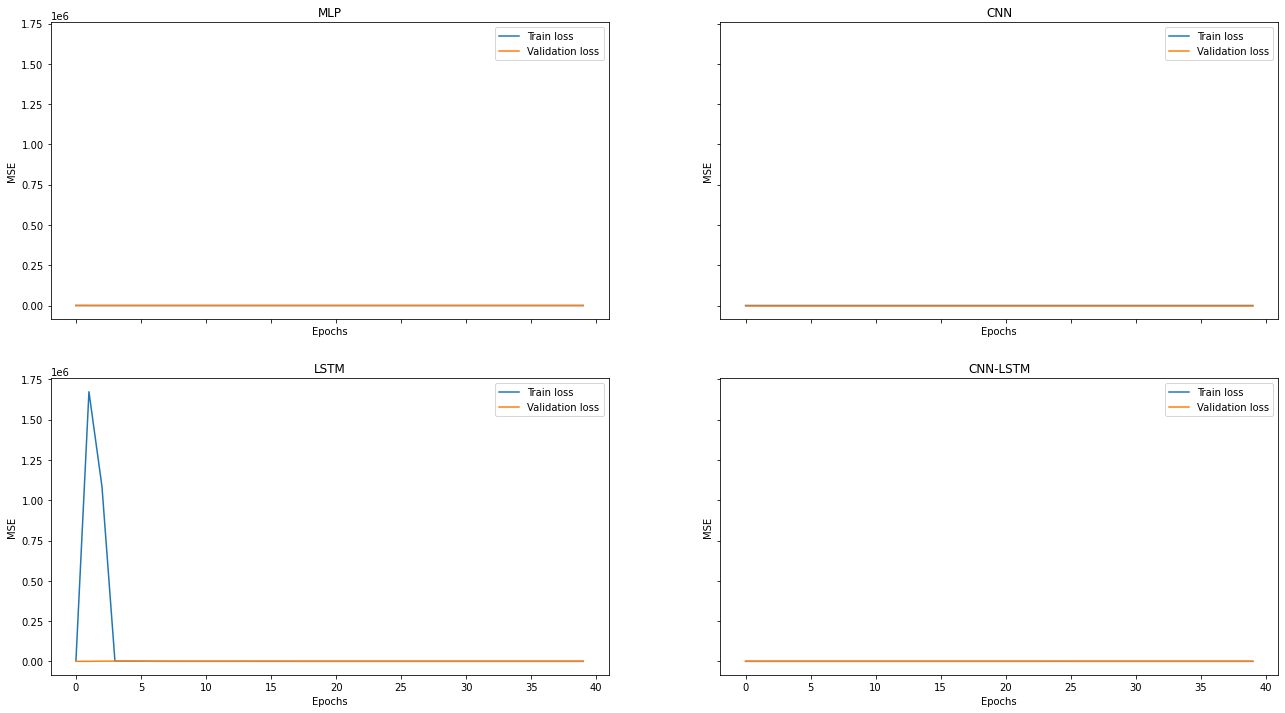

In [ ]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(22, 12))
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]

def plot_loss(ax, history, model_name):
    ax.plot(history['loss'], label='Train loss')
    ax.plot(history['val_loss'], label='Validation loss')
    ax.legend(loc='best')
    ax.set_title(model_name)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('MSE')

plot_loss(ax1, mlp_history.history, 'MLP')
plot_loss(ax2, cnn_history.history, 'CNN')
plot_loss(ax3, lstm_history.history, 'LSTM')
plot_loss(ax4, cnn_lstm_history.history, 'CNN-LSTM')

plt.show()